# FlowKit Tutorial - Part 1 - The `Sample` Class

https://flowkit.readthedocs.io/en/latest/?badge=latest

Welcome to the series of FlowKit tutorial notebooks! I hope you find these tutorials a helpful guide to using FlowKit for your FCM analysis. Part 1 covers the `Sample` class, the foundational class on which most of FlowKit is built. If you have any questions about FlowKit, find any bugs, or feel something is missing from these tutorials [please submit an issue to the GitHub repository here](https://github.com/whitews/FlowKit/issues/new/).

## Table of Contents

* [Sample Class](#Sample-Class)
  * [Create a Sample](#Create-Sample)
    * [From an FCS File](#From-an-FCS-File)
    * [From a pandas DataFrame or NumPy array](#From-a-pandas-DataFrame-or-NumPy-array)
  * [Metadata & Channel Information](#Metadata-and-Channel-Information)
  * [Subsampling](#Subsampling)
  * [Plotting Sample Events](#Plotting-Sample-Events)
    * [Histogram](#Histogram)
    * [Plot Channel](#Plot-Channel)
    * [Contour Plot](#Contour-Plot)
    * [Scatter Plot](#Interactive-Scatter-Plot)
    * [Scatterplot Matrix](#Interactive-Scatterplot-Matrix)
  * [Retrieving Events](#Retrieving-Events)
    * [Retrieve as NumPy array](#Retrieve-Events-as-NumPy-Array)
    * [Retrieve as pandas DataFrame](#Retrieve-Events-as-pandas-DataFrame)
  * [Exporting Events](#Exporting-Events)

In [1]:
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt

import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

Loading BokehJS ...

In [2]:
# check version so users can verify they have the same version/API
fk.__version__

'0.9.92b0'

## Sample Class

A Sample instance represents a single FCS sample, and is the only point of entry for FCS event data into the FlowKit library.

A Sample object can conveniently be created from a variety of data sources:
    
* A file path to an FCS file
* A pathlib Path object to an FCS file
* An already instantiated FlowIO FlowData object 
* A NumPy array (must provide sample_id & channel_labels)
* A Pandas DataFrame (with channel labels as headers, must provide sample_id)

Let's take a look at the Sample constructor method:

    Sample(
        fcs_path_or_data,
        id=None,
        channel_labels=None, 
        compensation=None, 
        null_channel_list=None, 
        ignore_offset_error=False, 
        ignore_offset_discrepancy=False,
        use_header_offsets=False,
        cache_original_events=False,
        subsample=10000
    )

* **fcs_path_or_data**: a data source for the FCS sample as described above
* **sample_id**: A text string to use for the Sample's ID. If None, the ID will be taken from the 'fil' keyword of the metadata. If the 'fil' keyword is not present, the value will be the filename if given a file. ***For a NumPy array or Pandas DataFrame, a text value is required.***
* **channel_labels**: A list of strings or a list of tuples to use for the channel labels. Required if fcs_path_or_data is a NumPy array
* **compensation**: Compensation matrix, which can be a:  
    - Matrix instance
    - NumPy array
    - CSV file path
    - pathlib Path object to a CSV or TSV file
    - string of CSV text
    - None (default) for no compensation (it can be applied later via the apply_comensation method)
* **null_channel_list**: List of PnN labels for channels that were collected but do not contain useful data. Note, this should only be used if there were truly no fluorochromes used targeting those detectors and the channels do not contribute to compensation.
* **ignore_offset_error**: An option to ignore data offset error (see note below for more details)
* **ignore_offset_discrepancy**: option to ignore discrepancy between the HEADER and TEXT values for the DATA byte offset location, default is False
* **use_header_offsets**: use the HEADER section for the data offset locations, default is False. Setting this option to True also suppresses an error in cases of an offset discrepancy.
* **cache_original_events**: Original events are the unprocessed events as stored in the FCS binary, meaning they have not been scaled according to channel gain, corrected for proper lin/log display, or had the time channel scaled by the 'timestep' keyword value (if present). By default, these events are not retained by the Sample class as they are typically not useful. To retrieve the original events, set this to True and call the get_orig_events() method.
* **subsample**: The number of events to use for sub-sampling. The number of sub-sampled events can be changed after instantiation using the `subsample_events` method. The random seed can also be specified using that method. Sub-sampled events are used predominantly for speeding up plotting methods.

**Note about FCS files with a data offset error:** 

Some FCS files incorrectly report the location of the last data byte as the last byte exclusive of the data section rather than the last byte inclusive of the data section. Technically, these are invalid FCS files but these are not corrupted data files. To attempt to read in these files, set the `ignore_offset_error` option to True.

**Note on `ignore_offset_discrepancy` and `use_header_offset`:**
The byte offset location for the DATA segment is defined in 2 places in an FCS file: the HEADER and the TEXT segments. By default, FlowIO uses the offset values found in the TEXT segment. If the HEADER values differ from the TEXT values, a DataOffsetDiscrepancyError will be raised. This option allows overriding this error to force the loading of the FCS file. The related `use_header_offset` can be used to force loading the file using the data offset locations found in the HEADER section rather than the TEXT section. Setting `use_header_offset` to True is equivalent to setting both options to True, meaning no error will be raised for an offset discrepancy.

**Event type names in the Sample class**

Several methods in the Sample class include a `source` argument that determines the type of events used or retrieved by the method. The options for the `source` argument are:

* `orig`
* `raw`
* `comp`
* `xform`

The `orig` option (for original events) is only available if the Sample object was instantiated with `cache_original_events` set to True. The original events are the events exactly as they were encoded in the FCS file, without applying the gain (from the $PnG keywords) or the time step from the FCS metadata. The original events are not typically useful for any processing.

The `raw` option specifies the event data that has been correctly pre-processed according the the channel gain and time step information.

The `comp` option specifies the event data as the raw data with a compensation matrix applied. These events are only available if a compensation matrix was specified in the Sample object instantiation or if the `apply_compensation` method has been called.

The `xform` option specifies transformed events. Transformed events will be stored post-compensation if a compensation matrix was supplied when creating a Sample instance or if the `apply_compensation` method has been called. Transformations can be also be applied to a non-compensated Sample.

***Applying compensation and transforms is covered in part 2 of the tutorial notebook series.***

Information is also available via the Python help function, along with descriptions of the Sample class methods:

```
help(fk.Sample)
```

### Create Sample

As stated above in the Sample docstring, a Sample instance can be created from a variety of data sources:

- File path to an FCS file
- pathlib Path object to an FCS file
- FlowIO FlowData object
- NumPy array (must provide sample_id & channel_labels)
- Pandas DataFrame (with channel labels as headers, must provide sample_id)

#### From an FCS File

Let's create a Sample instance from a file path to an FCS file.

In [3]:
fcs_path = '../../data/gate_ref/data1.fcs'

In [4]:
sample = fk.Sample(fcs_path)

In [5]:
sample

Sample(v2.0, B07, 8 channels, 13367 events)

The string representation tells us this is an FCS 2.0 file with the '$FIL' keyword value of 'B07'. There are 8 channels of event data with 13,367 total events.

#### From a pandas DataFrame or NumPy array

A Sample can also be created from a pandas DataFrame or a NumPy array. In both cases, a sample ID must be provided. For FCS files, this ID is read from the metadata, and without an ID other features of FlowKit will have no mechanism to reference a Sample.

Let's get a DataFrame from the previous Sample we made. We'll cover more on exporting events later in this tutorial, but for now we'll just use the `as_dataframe` method. Then, we can use it as an example of creating a new Sample instance.

In [6]:
df_events = sample.as_dataframe(source='raw')

In [7]:
sample_from_df = fk.Sample(df_events, sample_id='my_sample_from_dataframe')

In [8]:
sample_from_df

Sample(v3.1, my_sample_from_dataframe, 8 channels, 13367 events)

Creating a Sample from a NumPy array is similar, but we must also provide the channel names. In the case of the DataFrame above, the channel names were taken from the column names.

In [9]:
np_events = sample.get_events(source='raw')
channel_labels = sample.pnn_labels

In [10]:
sample_from_np = fk.Sample(np_events, channel_labels=channel_labels, sample_id='my_sample_from_numpy')

In [11]:
sample_from_np

Sample(v3.1, my_sample_from_numpy, 8 channels, 13367 events)

### Metadata and Channel Information

Get the FCS version of the file (returns None if a Sample was created from a NumPy array or Pandas DataFrame)

In [12]:
sample.version

'2.0'

Retrieve all the FCS metadata:

In [13]:
sample.get_metadata()

{'byteord': '4,3,2,1',
 'datatype': 'I',
 'nextdata': '0',
 'sys': 'Macintosh System Software 9.0.4',
 'creator': 'CELLQuestª 3.3',
 'tot': '13367',
 'mode': 'L',
 'par': '8',
 'p1n': 'FSC-H',
 'p1r': '1024',
 'p1b': '16',
 'p1e': '0,0',
 'p1g': '3.67',
 'p2n': 'SSC-H',
 'p2r': '1024',
 'p2b': '16',
 'p2e': '0,0',
 'p2g': '8',
 'p3n': 'FL1-H',
 'p3r': '1024',
 'p3b': '16',
 'p3e': '4,0',
 'p4n': 'FL2-H',
 'p4r': '1024',
 'p4b': '16',
 'p4e': '4,0',
 'p5n': 'FL3-H',
 'p5r': '1024',
 'p5b': '16',
 'p5e': '4,0',
 'p1s': 'FSC-Height',
 'p2s': 'SSC-Height',
 'p3s': 'CD4 FITC',
 'p4s': 'CD8 B PE',
 'p5s': 'CD3 PerCP',
 'p6n': 'FL2-A',
 'p6r': '1024',
 'p6b': '16',
 'p6e': '0,0',
 'timeticks': '100',
 'p7n': 'FL4-H',
 'p7r': '1024',
 'p7e': '4,0',
 'p7b': '16',
 'p7s': 'CD8 APC',
 'p8n': 'Time',
 'p8r': '1024',
 'p8e': '0,0',
 'p8b': '16',
 'p8s': 'Time (102.40 sec.)',
 'sample id': 'Default Patient ID',
 'src': 'Default',
 'case number': 'Default Case Number',
 'cyt': 'FACSCalibur',
 'cytnum

Retrieve a DataFrame of channel information, including the required PnN labels & optional PnS labels for each channel. Note that Samples distinguish between channel numbers and indices, with channel numbers being indexed at 1 and channel indices being indexed at 0.

In [14]:
sample.channels

channel_number    pnn                 pns   png         pne     pnr
0               1  FSC-H          FSC-Height  3.67  (0.0, 0.0)  1024.0
1               2  SSC-H          SSC-Height  8.00  (0.0, 0.0)  1024.0
2               3  FL1-H            CD4 FITC  1.00  (4.0, 1.0)  1024.0
3               4  FL2-H            CD8 B PE  1.00  (4.0, 1.0)  1024.0
4               5  FL3-H           CD3 PerCP  1.00  (4.0, 1.0)  1024.0
5               6  FL2-A                      1.00  (0.0, 0.0)  1024.0
6               7  FL4-H             CD8 APC  1.00  (4.0, 1.0)  1024.0
7               8   Time  Time (102.40 sec.)  1.00  (0.0, 0.0)  1024.0

Get a list of only the PnN labels:

In [15]:
sample.pnn_labels

['FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL2-A', 'FL4-H', 'Time']

The optional PnS labels are also available (empty values will be empty strings):

In [16]:
sample.pns_labels

['FSC-Height',
 'SSC-Height',
 'CD4 FITC',
 'CD8 B PE',
 'CD3 PerCP',
 '',
 'CD8 APC',
 'Time (102.40 sec.)']

The Sample class attempts to automatically identify fluorescent, scatter, and time channels. This is done by looking for simple sub-string values in channel names (i.e. 'FSC', 'SSC', 'Time'). The channel indices for these channel types are available using the following attributes:

In [17]:
sample.fluoro_indices

[2, 3, 4, 5, 6]

In [18]:
sample.scatter_indices

[0, 1]

In [19]:
sample.time_index

7

Lookup a channel index by a label string:

In [20]:
sample.get_channel_index('FL2-H')

3

Or, lookup a channel number:

In [21]:
sample.get_channel_number_by_label('FL2-H')

4

And for completeness, get a channel index via its number:

In [22]:
sample.get_channel_index(4)

3

To get the event count:

In [23]:
sample.event_count

13367

**Several other Sample attributes are available including:**

* `id`
* `original_filename`
* `acquisition_date`
* `compensation`
* `transform`

**And a few attributes for filtering events:**

* `subsample_indices`
  
  Set by constructor or by calling the `subsample_events` method (see below).


* `negative_scatter_indices`

  Set by calling the `filter_negative_scatter` method.


* `flagged_indices`

  Assigned manually by the user for flagging any events (anomolous events from a QC routine, etc.)

### Subsampling

FlowKit is optimized for performance (or attempts to be!). However, when dealing with high-dimensional flow cytometry data and/or data containing millions of events, it can be useful to sub-sample events to speed up processing. This is especially true when trying to plot events. All Sample plot methods, except for `plot_histogram` and `plot_channel`, use sub-sampled events by default (we'll see these methods in the next section).

On instantiation, the number of sub-sampled events can be specified (default is 10,000). The Sample class als provides a `subsample_events` method to change the number of sub-sample events or the random seed used to generate the sub-sample. The sub-sample is drawn randomly, but in a reproducible way. You can be guaranteed the same sub-sample indices when re-running analysis by providing the same random seed as an argument (default seed is 1). We can retrieve the subsampled indices using the `subsample_indices` attribute.

Note that sub-sampling does not delete any events, the sub-sampled indices are simply stored and used as a subset of events. Any Sample class method that plots or retrieves events will have a `subsample` argument that takes a Boolean value specifying whether to use the sub-sampled events or all events. Any method that processes events (compensating or transforming) will always use all the events.

**Retrieving sub-sampled indices**

Our Sample instance was already sub-sampled by default (at 10000 events) when creating the Sample. Note in the output below, the sub-sampled indices are not only randomly selected (in a reproducible way via the random seed), but are also randomly shuffled. This allows for safer sub-sampling the sub-sample if even fewer events are needed.

In [24]:
sample.subsample_indices

array([ 4136, 12180, 11048, ...,  9661, 10709, 10093])

### Plotting Sample Events

* Histogram
* Contour Plot
* Interactive Scatter Plot
* Interactive Scatter Plot Matrix

All plotting methods return a figure of either a Seaborn or Bokeh instance. This is done so the caller can modify and/or display the plot as required.

#### Histogram

In [25]:
help(sample.plot_histogram)

Help on method plot_histogram in module flowkit._models.sample:

plot_histogram(channel_label_or_number, source='xform', subsample=False, bins=None) method of flowkit._models.sample.Sample instance
    Returns a histogram plot of the specified channel events, available
    as raw, compensated, or transformed data. Plot also contains a curve
    of the gaussian kernel density estimate.
    
    :param channel_label_or_number:  A channel's PnN label or number to use
        for plotting the histogram
    :param source: 'raw', 'comp', 'xform' for whether the raw, compensated
        or transformed events are used for plotting
    :param subsample: Whether to use all events for plotting or just the
        sub-sampled events. Default is False (all events).
    :param bins: Number of bins to use for the histogram or a string compatible
        with the NumPy histogram function. If None, the number of bins is
        determined by the square root rule.
    :return: Matplotlib figure of the h

In [26]:
p = sample.plot_histogram('FSC-H', source='raw')
show(p)

Changing the bin size:

In [27]:
p = sample.plot_histogram('FSC-H', source='raw', bins=256)
show(p)

#### Plot Channel

The `plot_channel` method create a 2-D histogram of the specified channel data with the x-axis as the event index. This is similar to plotting a channel vs Time, except the events are equally distributed along the x-axis.

*Note: this method returns a Matplotlib Figure object instead of a Bokeh Figure*

In [28]:
help(sample.plot_channel)

Help on method plot_channel in module flowkit._models.sample:

plot_channel(channel_label_or_number, source='xform', flag_events=False) method of flowkit._models.sample.Sample instance
    Plot a 2-D histogram of the specified channel data with the x-axis as the event index.
    This is similar to plotting a channel vs Time, except the events are equally
    distributed along the x-axis.
    
    :param channel_label_or_number: A channel's PnN label or number
    :param source: 'raw', 'comp', 'xform' for whether the raw, compensated
        or transformed events are used for plotting
    :param flag_events: whether to flag events using stored flagged_event indices.
        Flagged event regions will be highlighted in red. Default is False.
    :return: Matplotlib Figure instance



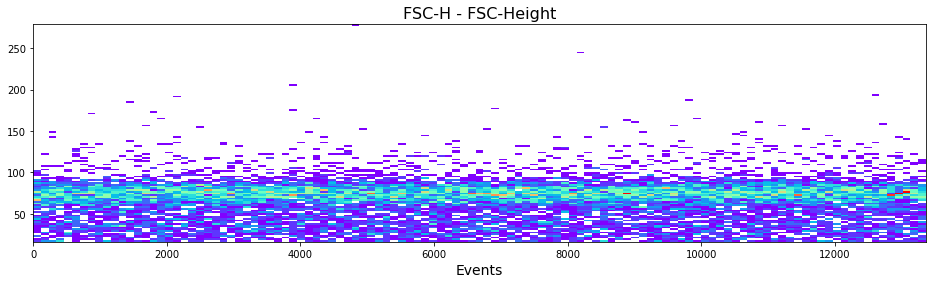

In [29]:
f = sample.plot_channel('FSC-H', source='raw')
plt.show(f)

#### Contour Plot

The `plot_contour` method uses the Kernel Density Estimate function from SciPy and is computationally intensive, so the plots can take some time to create.

In [30]:
help(sample.plot_contour)

Help on method plot_contour in module flowkit._models.sample:

plot_contour(x_label_or_number, y_label_or_number, source='xform', subsample=True, plot_contour=True, plot_events=False, x_min=None, x_max=None, y_min=None, y_max=None, fill=False, fig_size=(8, 8)) method of flowkit._models.sample.Sample instance
    Returns a contour plot of the specified channel events, available
    as raw, compensated, or transformed data.
    
    :param x_label_or_number:  A channel's PnN label or number for x-axis
        data
    :param y_label_or_number: A channel's PnN label or number for y-axis
        data
    :param source: 'raw', 'comp', 'xform' for whether the raw, compensated
        or transformed events are used for plotting
    :param subsample: Whether to use all events for plotting or just the
        sub-sampled events. Default is True (sub-sampled events). Running
        with all events is not recommended, as the Kernel Density
        Estimation is computationally demanding.
    :pa

In [31]:
# by default, plot_contour uses sub-sampled events for performance
f = sample.plot_contour('FSC-H', 'SSC-H', source='raw')

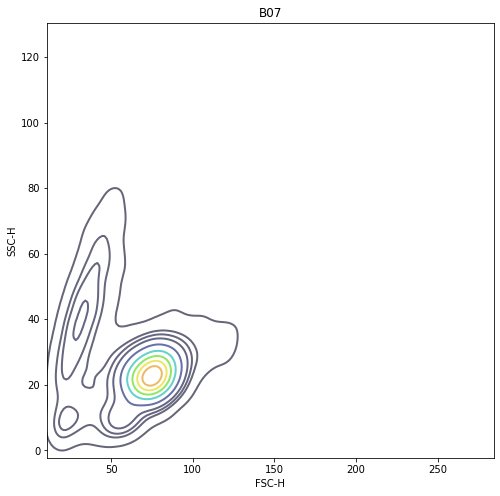

In [32]:
plt.show()

To specify the axes ranges:

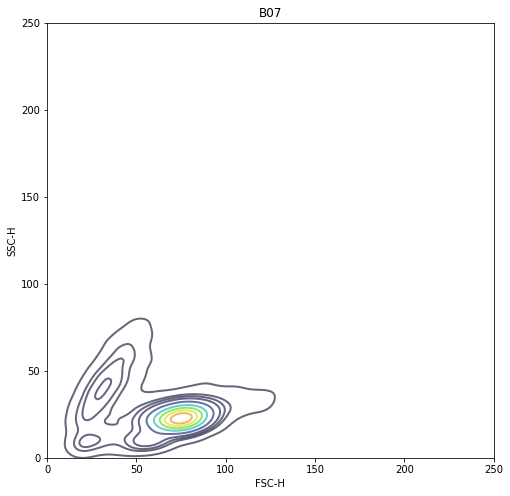

In [33]:
x_min = y_min = 0
x_max = y_max = 250

f = sample.plot_contour(
    'FSC-H', 'SSC-H', source='raw', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max
)
plt.show(f)

Fill contours:

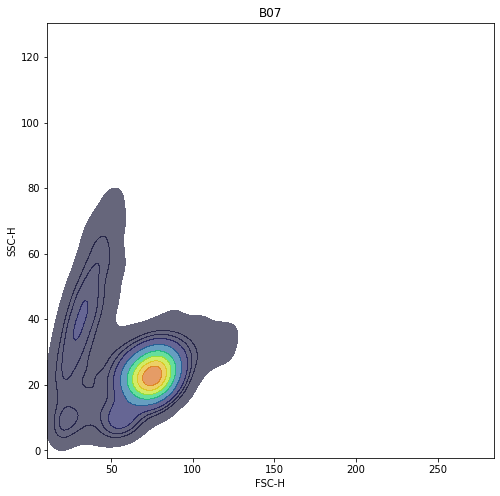

In [34]:
f = sample.plot_contour('FSC-H', 'SSC-H', fill=True, source='raw')
plt.show()

Adding events for a non-interactive scatter plot (but not as fast as the true scatter plot method):

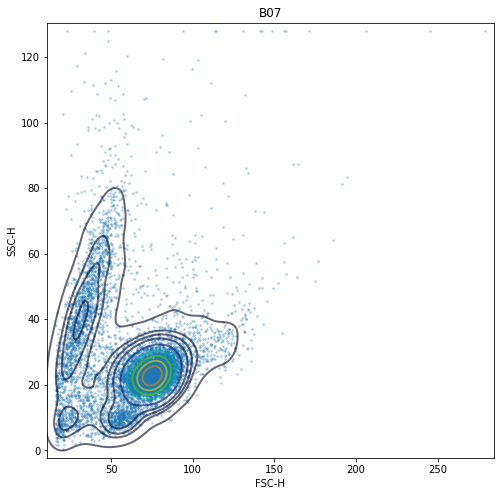

In [35]:
f = sample.plot_contour('FSC-H', 'SSC-H', source='raw', plot_events=True)
plt.show()

#### Interactive Scatter Plot

The plot_scatter method uses Bokeh and is much faster

In [36]:
p = sample.plot_scatter(
    'FSC-H', 'SSC-H',
    source='raw', y_min=0., y_max=130, x_min=0., x_max=280, color_density=True
)

In [37]:
show(p)

Change the bin width to control the color density. The bin width is in units of the event point size and the default is 4 for a 4x4 grid size. Larger values will create a smoother color gradient but will lose detail. Let's set the bin size to 8 and see how it compares.

In [38]:
p = sample.plot_scatter(
    'FSC-H', 'SSC-H',
    source='raw', y_min=0., y_max=130, x_min=0., x_max=280, color_density=True, bin_width=8
)

In [39]:
show(p)

Or, turn off the color density completely:

In [40]:
p = sample.plot_scatter('FSC-H', 'SSC-H', source='raw', color_density=False)
show(p)

**Apply a transform and plot fluorescent channels (raw and transformed)**

*Note: The `transforms` module will be covered in more detail in part 2 of the tutorial notebook series*

In [41]:
xform = fk.transforms.LogicleTransform('asinh', param_t=1024, param_w=0.5, param_m=4.5, param_a=0)
sample.apply_transform(xform)

In [42]:
# source is 'raw' so not too useful for visualization
p = sample.plot_scatter('FL1-H', 'FL2-H', source='raw')
show(p)

In [43]:
# change source to 'xform' to visualize the transformed data
p = sample.plot_scatter('FL1-H', 'FL2-H', source='xform')
show(p)

**Highlight Specific Events**

You can also highlight certain events to only apply the color density to them using a Boolean array. The density calculation is still based on all the events. Let's highlight all events with CD3 values above 0.65.

In [44]:
# cd3 is channel index 4 (channel number 5)
cd3_xform_events = sample.get_channel_events(4, source='xform')
is_high_cd3 = cd3_xform_events > 0.65

In [45]:
p = sample.plot_scatter('FL3-H', 'FSC-H', source='xform', highlight_indices=is_high_cd3)
show(p)

But let's show these events on a plot of CD4 vs CD8.

In [46]:
p = sample.plot_scatter('FL1-H', 'FL2-H', source='xform', highlight_indices=is_high_cd3)
show(p)

#### Interactive Scatterplot Matrix

In [47]:
help(sample.plot_scatter_matrix)

Help on method plot_scatter_matrix in module flowkit._models.sample:

plot_scatter_matrix(channel_labels_or_numbers=None, source='xform', subsample=True, color_density=False, plot_height=256, plot_width=256) method of flowkit._models.sample.Sample instance
    Returns an interactive scatter plot matrix for all channel combinations
    except for the Time channel.
    
    :param channel_labels_or_numbers: List of channel PnN labels or channel
        numbers to use for the scatter plot matrix. If None, then all
        channels will be plotted (except Time).
    :param source: 'raw', 'comp', 'xform' for whether the raw, compensated
        or transformed events are used for plotting
    :param subsample: Whether to use all events for plotting or just the
        sub-sampled events. Default is True (sub-sampled events). Plotting
        sub-sampled events is much faster.
    :param color_density: Whether to color the events by density, similar
        to a heat map. Default is False.
  

In [48]:
# For the scatter matrix, sub-sampling is usually a good idea since there are so many plots
spm = sample.plot_scatter_matrix(
    source='xform', 
    channel_labels_or_numbers=['FSC-H', 'SSC-H', 'FL3-H', 'FL4-H'],
    color_density=True
)
show(spm)

### Retrieving Events

Several methods are available in the Sample class for convenient retrieval event data, and in a variety of forms.

#### Retrieve Events as NumPy Array

The Sample methods `get_events` and `get_channel_events` return event data as a NumPy array. Both methods have similar input arguments, including the already familiar `source` and `subsample` arguments for specifying the event class ('orig', 'raw', 'comp', or 'xform') and whether to return the sub-sampled events or all events.

***Note: These methods return the arrays directly, not a copy of the array. Be careful if you are planning to modify the returned event data, and make a copy of the array when appropriate.***

In [49]:
help(sample.get_events)

Help on method get_events in module flowkit._models.sample:

get_events(source='xform', subsample=False) method of flowkit._models.sample.Sample instance
    Returns a NumPy array of event data.
    
    Note: This method returns the array directly, not a copy of the array. Be careful if you
    are planning to modify returned event data, and make a copy of the array when appropriate.
    
    :param source: 'orig', 'raw', 'comp', 'xform' for whether the original (no gain applied),
        raw (orig + gain), compensated (raw + comp), or transformed (comp + xform) events will
        be returned
    :param subsample: Whether to return all events or just the sub-sampled
        events. Default is False (all events)
    :return: NumPy array of event data



In [50]:
sample.get_events(source='raw')

array([[ 88.01089918,  27.25      ,   7.23394163, ...,   5.        ,
          5.18613419,   0.        ],
       [ 19.07356948,   5.375     ,  36.51741273, ...,   0.        ,
          4.29351021,   0.        ],
       [ 70.57220708,  26.        ,   2.48045441, ...,   0.        ,
          8.58210354,   0.        ],
       ...,
       [ 62.1253406 ,  27.625     ,  11.75743266, ...,   0.        ,
          1.77827941, 174.        ],
       [ 36.23978202,  64.5       ,   5.42469094, ...,   0.        ,
          4.95806824, 174.        ],
       [ 66.48501362,   8.75      ,   1.43301257, ...,   0.        ,
          6.0429639 , 174.        ]])

In [51]:
# The Sample method `get_channel_events` takes a `channel_index` argument.
# Note the channel index (indexed at zero) and not the channel number.
channel_idx = sample.get_channel_index('FSC-H')
sample.get_channel_events(channel_idx, source='raw')

array([88.01089918, 19.07356948, 70.57220708, ..., 62.1253406 ,
       36.23978202, 66.48501362])

#### Retrieve Events as pandas DataFrame

The Sample method `as_dataframe` returns a pandas DataFrame of the Sample event data. This method also supports `source` and `subsample` arguments, but includes the extra arguments `col_order` and `col_names` for choosing the order of columns by PnN label and/or specifying new names for the columns in the returned DataFrame.

In [52]:
sample.as_dataframe(source='xform')

pnn        FSC-H      SSC-H     FL1-H     FL2-H     FL3-H     FL2-A     FL4-H  \
pns   FSC-Height SSC-Height  CD4 FITC  CD8 B PE CD3 PerCP             CD8 APC   
0      88.010899     27.250  0.517297  0.672002  0.559629  0.479774  0.483514   
1      19.073569      5.375  0.677265  0.307901  0.826510  0.111111  0.464115   
2      70.572207     26.000  0.406638  0.574814  0.427576  0.111111  0.534479   
3      98.910082     31.750  0.489024  0.589944  0.450145  0.111111  0.510031   
4      29.972752     34.750  0.413327  0.414281  0.413327  0.111111  0.500007   
...          ...        ...       ...       ...       ...       ...       ...   
13362  66.212534     19.625  0.512758  0.585500  0.412373  0.111111  0.496352   
13363  70.844687     25.500  0.527257  0.619182  0.443591  0.111111  0.510031   
13364  62.125341     27.625  0.565889  0.628894  0.414281  0.111111  0.370872   
13365  36.239782     64.500  0.488107  0.486271  0.518204  0.111111  0.478911   
13366  66.485014      8.750  0.347347  0.323674  0.329598  0.111111  0.499094   

pnn                 Time  
pns   Time (102.40 sec.)  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
13362              174.0  
13363              174.0  
13364              174.0  
13365              174.0  
13366              174.0  

[13367 rows x 8 columns]

### Exporting Events

The `export` method exports the event data to either a new FCS file or a CSV file, with the format determined by filename extension (either '.fcs' or '.csv'). Extra options are available for excluding certain events (negative scatter, flagged, subsample) from the exported file.

In [53]:
help(sample.export)

Help on method export in module flowkit._models.sample:

export(filename, source='xform', exclude_neg_scatter=False, exclude_flagged=False, exclude_normal=False, subsample=False, include_metadata=False, directory=None) method of flowkit._models.sample.Sample instance
    Export Sample event data to either a new FCS file or a CSV file. Format determined by filename extension.
    
    :param filename: Text string to use for the exported file name. File type is determined by
        the filename extension (supported types are .fcs & .csv).
    :param source: 'orig', 'raw', 'comp', 'xform' for whether the original (no gain applied),
        raw (orig + gain), compensated (raw + comp), or transformed (comp + xform) events  are
        used for exporting
    :param exclude_neg_scatter: Whether to exclude negative scatter events. Default is False.
    :param exclude_flagged: Whether to exclude flagged events. Default is False.
    :param exclude_normal: Whether to exclude "normal" events. Th